# Tutorial - example analysis with Quantus

This notebook shows the some different types of analysie that can be conducted with Quantus.

For this purpose, we use a pre-trained VGG-16 model and ImageNet dataset. A description for how to download the dataset can be found here: https://image-net.org/download.php.


- Make sure to have GPUs enabled to speed up computation.
- Skip running the first cell if you do not use Google Colab.

In [2]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages.
from IPython.display import clear_output
!pip install captum opencv-python xmltodict plotly-express
clear_output()

In [3]:
# Imports general.
import sys
import gc
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2
import PIL
from xml.etree import ElementTree
import xmltodict
import collections
from typing import Callable, Union
import copy
import json

# Plotting specifics.
import seaborn as sns
import plotly.express as px
from plotly.io import write_image
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Import package.
path = "/content/drive/MyDrive/Projects"
sys.path.append(f'{path}/quantus')
import quantus

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Configs torch (read more on this cuda-related issue here: https://github.com/pytorch/pytorch/issues/45769).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
#warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
clear_output()

#plt.style.use('seaborn-white')
#sns.set(font_scale=1.5)

## 1 Preliminaries

### 1.1 Load and prepare datasets

We load test samples from ImageNet.

In [4]:
# For the localisation metrics we need to load a dataset that has ground truth masks.

def load_sample(path: str) -> dict:
    """Read data as image and path. """
    return {"input": PIL.Image.open(path).convert("RGB"), "path": path}

def load_binary_mask(filename: str, path_data: str):
    """Load the binary mask for the given path of the data in the correct format. """
    binary_mask = {}
    
    filename = os.path.splitext(filename)[0]
    
    # Get label and file name.
    label = filename.split("/")[-2]
    fname = filename.split("_")[-1]

    # Parse annotations.
    tree = ElementTree.parse(os.path.join(path_data, "Annotation/{}/{}_{}.xml".format(label, label, fname)))
    xml_data = tree.getroot()
    xmlstr = ElementTree.tostring(xml_data, encoding="utf-8", method="xml")
    annotation = dict(xmltodict.parse(xmlstr))['annotation']

    width = int(annotation["size"]["width"])
    height = int(annotation["size"]["height"])

    # Iterate objects.
    objects = annotation["object"]

    if type(objects) != list:
        mask = np.zeros((height, width), dtype=int)
        mask[int(objects['bndbox']['ymin']):int(objects['bndbox']['ymax']), 
             int(objects['bndbox']['xmin']):int(objects['bndbox']['xmax'])] = 1
        binary_mask[objects['name']] = mask

    else:
        for object in annotation['object']:
            if type(object) == collections.OrderedDict:
                if object['name'] in binary_mask.keys():
                    mask = binary_mask[object['name']]
                else:
                    mask = np.zeros((height, width), dtype=np.uint8)

                mask[int(object['bndbox']['ymin']):int(object['bndbox']['ymax']),
                     int(object['bndbox']['xmin']):int(object['bndbox']['xmax'])] = 1

                binary_mask[object['name']] = mask

    # Preprocess binary masks to fit shape of image data.
    for key in binary_mask.keys():
        binary_mask[key] = cv2.resize(binary_mask[key], 
                                      (224, 224),
                                      interpolation=cv2.INTER_NEAREST).astype(np.int)[:, :, np.newaxis]

    return binary_mask


class CustomTransform(torch.nn.Module):
    """Custom transformation to handle image processing and binary mask processing simultaneously. """
    
    image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __init__(self, path):
        super().__init__()
        self.path = path
        
    def __call__(self, img):
        return {"input": self.image_transform(img["input"]), 
                "mask": load_binary_mask(img["path"], self.path)}
    
def CustomCollate(batch):
    """Collate function to pack the image, mask and label data accordingly. """
    inputs = []
    targets = []
    masks = []
    custom_classindices = [96, 126, 155, 292, 301, 347, 387, 405, 417, 426, 446, 546, 565, 573, 604, 758, 844, 890, 937, 954]
    
    for b in batch:
        inputs.append(b[0]["input"])
        masks.append(b[0]["mask"])
        targets.append(custom_classindices[b[1]])
    
    # Rearrange masks, inputs and targets.
    masks = torch.Tensor(np.array([m[list(m.keys())[0]][:, :, 0] for m in masks]))
    inputs = torch.stack(inputs, 0)
    targets = torch.tensor(targets)

    return inputs, masks, targets

def get_imagenet_labels():
    # Make a int-string label mapping for Imagenet classes.
    mapping = {}
    with open(f'{path}/quantus/tutorials/assets/imagenet_labels.txt', 'r') as f:
        for ix, line in enumerate(f):
            if ix not in [0, 1001]:
                line = line.split('b" ')[0]
                key = line.split(':')[0]
                value = line.split(": '")[1].split("',\n")[0]
                mapping[int(key)] = str(value)

    return mapping

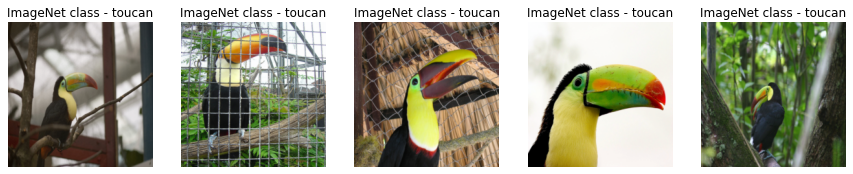

In [5]:
# Load test data and make loaders.
batch_size = 233
path_data = 'drive/MyDrive/Projects/quantus/tutorials/assets/imagenet_images/'
dataset = torchvision.datasets.DatasetFolder(os.path.join(path_data, "bboxes_images/"), 
                                             loader=load_sample, 
                                             extensions=(".jpeg", "png"),
                                             transform=CustomTransform(path=path_data))
test_loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size, collate_fn=CustomCollate)

# Load a batch of inputs, segmentation masks and outputs to use for evaluation.
x_batch, s_batch, y_batch = iter(test_loader).next()
x_batch, s_batch, y_batch = x_batch.to(device), s_batch.to(device), y_batch.to(device)

# Get imagenet labels
mapping = get_imagenet_labels()

# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.moveaxis(quantus.denormalise(x_batch[i].cpu().numpy()), 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {mapping[y_batch[i].item()]}")
    axes[i].axis("off")
plt.show()


### 1.2 Load a pre-trained model

In this example we load a pre-trained VGG-16 model.

In [6]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, _, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
            
    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())
    
# Load pre-trained (ResNet18, VGG16) model.
model = torchvision.models.vgg16(pretrained=True) 
model = model.to(device)

# Evaluate model performance.
print(f"\nModel test accuracy: {(100 * evaluate_model(model.to(device), test_loader, device)):.2f}%")

# Posterior mean model, the estimator with minimum loss.
posterior_mean = copy.deepcopy(model.state_dict())

#model = torchvision.models.resnet18(pretrained=True)
#list(model.named_modules())[-4][1]

#model = torchvision.models.vgg16(pretrained=True) 
#list(model.named_modules())[-12][1]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


Model test accuracy: 88.89%


### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [7]:
def saliency_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's Saliency implementation."""

    gc.collect()
    torch.cuda.empty_cache()
    
    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(
            kwargs.get("device", None))  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        Saliency(model)
            .attribute(inputs, targets, abs=abs)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
            .cpu()
            .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def inputxgrad_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's Input x Gradient implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(
            kwargs.get("device", None))  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        InputXGradient(model)
            .attribute(inputs, targets)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
            .cpu()
            .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def lrp_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's LRP implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(
            kwargs.get("device", None))  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        LRP(model)
            .attribute(inputs, targets)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
            .cpu()
            .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def intgrad_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's Integrated Gradients implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        IntegratedGradients(model)
            .attribute(inputs=inputs, target=targets, baselines=torch.zeros_like(inputs), n_steps=10,
                method="riemann_trapezoid",)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
            .cpu()
            .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def gradshap_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's GradShap implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    
    baselines = torch.zeros_like(inputs).to(kwargs.get("device", None))
    explanation = (
        GradientShap(model)
            .attribute(inputs=inputs, target=targets, baselines=baselines)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
            .cpu()
            .data
    )

    gc.collect()
    torch.cuda.empty_cache()
    
    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def gradcam_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's GradCam implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation_small = (LayerGradCam(model, layer=list(model.named_modules())[-4][1])
            .attribute(inputs=inputs, target=targets)
            .sum(axis=1)
            .cpu()
            .detach()
            .numpy())

    explanation = torch.zeros((inputs.shape[0], kwargs.get("img_size", 224), kwargs.get("img_size", 224)))

    for i in range(len(explanation)):
        explanation[i] = torch.Tensor(cv2.resize(explanation_small[i], dsize=((kwargs.get("img_size", 224), kwargs.get("img_size", 224)))))

    gc.collect()
    torch.cuda.empty_cache()
    

    if normalise:   
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def fusiongrad_explainer(model, inputs, targets, abs=False, normalise=False, *args, **kwargs) -> np.array:
    """Wrapper aorund captum's FusionGrad implementation."""

    std = kwargs.get("std", 0.6)
    mean = kwargs.get("mean", 1.0)
    n = kwargs.get("n", 10)
    m = kwargs.get("m", 10)
    sg_std = kwargs.get("sg_std", 0.0)
    sg_mean = kwargs.get("sg_mean", 0.3)
    posterior_mean = kwargs.get("posterior_mean", None)
    noise_type = kwargs.get("noise_type", "multiplicative")
    clip = kwargs.get("clip", False)
    
    # Creates a normal (also called Gaussian) distribution.
    distribution = torch.distributions.normal.Normal(
        loc= torch.as_tensor(mean, dtype=torch.float), scale=torch.as_tensor(std, dtype=torch.float)
    )

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
                .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
                .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None)) 

    assert (
            len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (n, m, inputs.shape[0], kwargs.get("img_size", 224), kwargs.get("img_size", 224)))
    else:
        explanation = torch.zeros((n, m, kwargs.get("img_size", 224), kwargs.get("img_size", 224)))

    for i in range(n):
        model = _sample(model=model, posterior_mean=posterior_mean, std=std, distribution=distribution, noise_type=noise_type)
        for j in range(m):
            inputs_noisy = (inputs + torch.randn_like(inputs) * sg_std + sg_mean)
            if clip:
                inputs_noisy = torch.clip(inputs_noisy, min=0.0, max=1.0)

            explanation[i][j] = (Saliency(model).attribute(inputs_noisy, targets, abs=abs)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
            .cpu()
            .data)
            
    explanation = explanation.mean(axis=(0, 1))

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def _sample(model, posterior_mean, std, distribution=None, noise_type="multiplicative"):
    """Implmentation to sample a model."""
    
    # Load model params.
    model.load_state_dict(posterior_mean)
    
    # If std is not zero, loop over each layer and add Gaussian noise.
    if not std == 0.0:
        with torch.no_grad():
            for layer in model.parameters():
                if noise_type == "additive":
                    layer.add_(
                        distribution.sample(layer.size()).to(layer.device)
                    )
                elif noise_type == "multiplicative":
                    layer.mul_(
                        distribution.sample(layer.size()).to(layer.device)
                    )
                else:
                    print(
                        "Set NoiseGrad attribute 'noise_type' to either 'additive' or 'multiplicative' (str)."
                    )

    return model


def explainer_wrapper(**kwargs):
    """Wrapper for explainer functions."""
    if kwargs["method"] == "Saliency":
        return saliency_explainer(**kwargs)
    elif kwargs["method"] == "IntegratedGradients":
        return intgrad_explainer(**kwargs)
    elif kwargs["method"] == "GradCam":
        return gradcam_explainer(**kwargs)
    elif kwargs["method"] == "LRP":
        return lrp_explainer(**kwargs)
    elif kwargs["method"] == "FusionGrad":
        return fusiongrad_explainer(**kwargs)
    elif kwargs["method"] == "InputxGradient":
        return inputxgrad_explainer(**kwargs)
    elif kwargs["method"] == "GradientShap":
        return gradshap_explainer(**kwargs)
    else:
        raise ValueError("Pick an explaination function that exists.")


In [8]:
# Draw n random indices from batch! 
nr_samples_viz = 10
index_we_want = [108, 158, 85, 82, 2]
sample_indices_viz = np.random.choice(np.arange(0, batch_size-1), size=nr_samples_viz)

for ind in index_we_want:
    if ind not in sample_indices_viz:
        sample_indices_viz = np.append(arr=sample_indices_viz, values=[ind])
        nr_samples_viz +=1

# For reproducibility purposes we hardcode the same indices.
nr_samples_viz = 14
sample_indices_viz = np.array([117,  60,  19, 134,  15, 146, 175,  86, 193,  73, 108, 158,  85,  82])

nr_samples_viz, sample_indices_viz


(14, array([117,  60,  19, 134,  15, 146, 175,  86, 193,  73, 108, 158,  85,
         82]))

In [9]:
visualise = False

# Produce explanations.
if not pathlib.Path(f"{path}/quantus/tutorials/assets/analysis/analysis_explanations.json").is_file():

    gc.collect()
    torch.cuda.empty_cache()
    a_batch_saliency = saliency_explainer(model=model,
                                        inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224),
                                        targets=y_batch[sample_indices_viz],
                                        normalise=False,
                                        abs=False)

    gc.collect()
    torch.cuda.empty_cache()
    a_batch_gradshap = gradshap_explainer(model=model, 
                                        inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224),
                                        targets=y_batch[sample_indices_viz], 
                                        normalise=False, 
                                        abs=False)

    gc.collect()
    torch.cuda.empty_cache()
    a_batch_intgrad = intgrad_explainer(model=model,
                                        inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224),
                                        targets=y_batch[sample_indices_viz],
                                        normalise=False,
                                        abs=False)

    gc.collect()
    torch.cuda.empty_cache()
    a_batch_gradcam = gradcam_explainer(model=model, 
                                        inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224), 
                                        targets=y_batch[sample_indices_viz], 
                                        normalise=False, 
                                        abs=False, 
                                        **{"gc_layer": list(model.named_modules())[-12][1]}) # for ResNet-18: list(model.named_modules())[-4][1]

    gc.collect()
    torch.cuda.empty_cache()
    a_batch_inputxgrad = inputxgrad_explainer(model=model,
                                        inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224),
                                        targets=y_batch[sample_indices_viz],
                                        normalise=False,
                                        abs=False)

    gc.collect()
    torch.cuda.empty_cache()
    a_batch_lrp = lrp_explainer(model=model,
                                inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224), 
                                targets=y_batch[sample_indices_viz],
                                normalise=False,
                                abs=False)
    gc.collect()
    torch.cuda.empty_cache()    
    a_batch_fusiongrad = fusiongrad_explainer(model=model, 
                                            inputs=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224), 
                                            targets=y_batch[sample_indices_viz], 
                                            normalise=False,
                                            abs=False,
                                            **{"posterior_mean": posterior_mean, "mean": 1.0, "std": 0.6, 
                                                "sg_mean": 0.0, "sg_std": 0.4, "n": 25, "m": 25, 
                                                "noise_type": "multiplicative"})

    # Save explanations to file.
    explanations = {"Saliency": a_batch_saliency.tolist(),
                    "GradientShap": a_batch_gradshap.tolist(),
                    "IntegratedGradients": a_batch_intgrad.tolist(),
                    "LRP": a_batch_lrp.tolist(),
                    "InputxGradient": a_batch_inputxgrad.tolist(),
                    "FusionGrad": a_batch_fusiongrad.tolist()}


    with open(f"{path}/quantus/tutorials/assets/analysis/analysis_explanations.json", 'w') as f:
        f.write(json.dumps(explanations))
        f.close()
else:

    # Open explanations!
    with open(f"{path}/quantus/tutorials/assets/analysis/analysis_explanations.json", 'r') as f:
        explanations = json.load(f)
        f.close()
        
    for k, v in explanations.items():
        explanations[k] = np.array(v)

    # Visualise some LRP explantions.
    if visualise:

        for img_choice in sample_indices_viz:

            print(img_choice)
            index = np.where(sample_indices_viz == img_choice)[0][0]

            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            axes[0].imshow(np.moveaxis(quantus.denormalise(x_batch[img_choice].detach().cpu().numpy(), **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
            axes[0].title.set_text(f"ImageNet - {y_batch[img_choice].item()}")
            axes[0].axis("off"); 
            axes[1].imshow(quantus.normalise_by_negative(explanations["FusionGrad"][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
            axes[0].title.set_text(f"FusionGrad")
            axes[1].axis("off"); plt.show()

## 2 Analysis and visualisations

In the following sections, we analyse the set of explanations under different perspectives:

- qualitative
- qualitative
- sensitivity

### 2.1 Qualitative analysis

First, we visualise the explanations.

In [53]:
# Plotting configs.
colours_order = ["#008080", "#FFA500", "#124E78", "#d62728"]
methods_order = ["Saliency (SA)", "Integrated\nGradients (IG)", "GradientShap (GS)", "FusionGrad (FG)"]

plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
include_titles = True

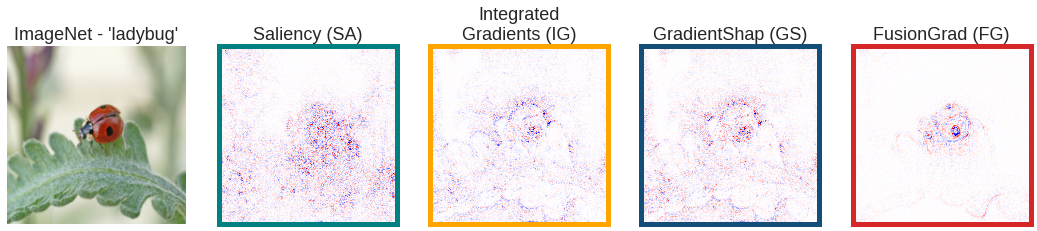

In [ ]:
# Plot explanations!
img_choice = 108
index = np.where(sample_indices_viz == img_choice)[0][0]
ncols = 5

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, int(ncols)*3))

for i in range(ncols):

    if i == 0:
        axes[0].imshow(np.moveaxis(quantus.denormalise(x_batch[img_choice].detach().cpu().numpy(), **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
        if include_titles:
            axes[0].set_title(f"ImageNet - 'ladybug'", fontsize=18) # To get the full name, replace with: {mapping[y_batch[img_choice].detach().cpu().numpy().item()].capitalize()}
            axes[0].axis("off")
    
    else:
        
        xai = methods_order[i-1].split("(")[0].replace(" ", "").replace("\n", "")
        
        axes[i].imshow(quantus.normalise_by_negative(explanations[xai][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
        if include_titles:
            axes[i].set_title(f"{methods_order[i-1]}", fontsize=18)

        # Frame configs.
        axes[i].xaxis.set_visible([])
        axes[i].yaxis.set_visible([])
        axes[i].spines["top"].set_color(colours_order[i-1])
        axes[i].spines["bottom"].set_color(colours_order[i-1])
        axes[i].spines["left"].set_color(colours_order[i-1])
        axes[i].spines["right"].set_color(colours_order[i-1])
        axes[i].spines["top"].set_linewidth(5)
        axes[i].spines["bottom"].set_linewidth(5)
        axes[i].spines["left"].set_linewidth(5)
        axes[i].spines["right"].set_linewidth(5)

plt.tight_layout()
plt.savefig(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_qualitative_plot_tutorial.png', dpi=400)
plt.show()

From this visualisation, it is hard a decipher which explanation method may be preferred in the task of explaining the Imagenet input.

### 2.2 Quantiative analysis

Second, we use Quantus to be able to quantiatively assess the different explanation methods on various evaluation criteria.

In [ ]:
# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

Note that for the empirical interpretations of the different categories exist and you can freely choose which one make most sense in your application/ data/ model context.

In [ ]:
# Define XAI methods and metrics.
xai_methods = ["Saliency", "IntegratedGradients", "GradientShap", "FusionGrad"]
metrics =  {"Robustness": quantus.AvgSensitivity(**{"nr_samples": 10,
                                                "perturb_std": 0.2,
                                                "norm_numerator": quantus.fro_norm,
                                                "norm_denominator": quantus.fro_norm,
                                                "perturb_func": quantus.uniform_noise,
                                                "similarity_func": quantus.difference,
                                                "disable_warnings": True}),
            "Faithfulness": quantus.FaithfulnessCorrelation(**{"nr_runs": 50,  
                                                "subset_size": 224,  
                                                "perturb_baseline": "black",
                                                "perturb_func": quantus.baseline_replacement_by_indices,
                                                "similarity_func": quantus.correlation_pearson,  
                                                "return_aggregate": True,
                                                "abs": False,  
                                                "normalise": False,
                                                "disable_warnings": True}),
            "Localisation": quantus.RelevanceRankAccuracy(**{"abs": True,  
                                                "normalise": False,
                                                "disable_warnings": True}),
            "Complexity": quantus.Sparseness(**{"abs": True,  
                                                "normalise": False,
                                                "disable_warnings": True}),
            "Randomisation": quantus.RandomLogit(**{"abs": False,  
                                                    "normalise": False,
                                                    "num_classes": 1000,
                                                    "similarity_func": quantus.ssim,
                                                    "disable_warnings": True})
           }

# Prepare results dict.
results = {}
for method in xai_methods:
    results[method] = {}


# Score explanation methods using Quantus.
if not pathlib.Path(f"{path}/quantus/tutorials/assets/analysis/analysis_viz_spyder_data.json").is_file():

    for method in xai_methods:
        for metric, metric_func in metrics.items():        

            print(method, ":", metric)
            gc.collect()
            torch.cuda.empty_cache()

            scores = metric_func(model=model,
                            x_batch=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224).detach().cpu().numpy(),
                            y_batch=y_batch[sample_indices_viz].detach().cpu().numpy(),
                            a_batch=None,
                            s_batch=s_batch[sample_indices_viz].reshape(nr_samples_viz, 1, 224, 224).detach().cpu().numpy(),
                            **{"explain_func": explainer_wrapper,
                            "method": method,
                                "device": device,
                                "img_size": 224,
                                "nr_channels": 3,
                                "posterior_mean": posterior_mean, 
                                "mean": 1.0, 
                                "std": 0.6, 
                                "sg_mean": 0.0, 
                                "sg_std": 0.4,
                                "n": 5,
                                "m": 5,
                                "noise_type": "multiplicative"})
        
            results[method][metric] = scores

            gc.collect()
            torch.cuda.empty_cache()

else:
    
    # Open explanations!
    with open(f"{path}/quantus/tutorials/assets/analysis/analysis_viz_spyder_data.json", 'r') as f:
        results = json.load(f)
        f.close()

    # Hard coded here for reproducability reasons.

    results = {'FusionGrad': {'Complexity': 0.2174073288037181,
                            'Faithfulness': 0.08527664082305754,
                            'Localisation': 0.7778848579895464,
                            'Randomisation': 0.9705829982421673,
                            'Robustness': 0.0036456280920122352},
            'GradientShap': {'Complexity': 0.6369435903106687,
                            'Faithfulness': -0.014105951461101936,
                            'Localisation': 0.6808766464099545,
                            'Randomisation': 0.4456949912964108,
                            'Robustness': 0.07008496432432107},
            'IntegratedGradients': {'Complexity': 0.5771733221443226,
                            'Faithfulness': 0.000889664022289325,
                            'Localisation': 0.6717197945606089,
                            'Randomisation': 0.8618395558296159,
                            'Robustness': 0.017174409835466316},
            'Saliency': {'Complexity': 0.4758911348795865,
                            'Faithfulness': 0.09727597535491624,
                            'Localisation': 0.6972319600946968,
                            'Randomisation': 0.7582642466570219,
                            'Robustness': 0.024734255392104387}}

# Postprocessing of scores: to get how the different explanation methods rank across criteria.

results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()
df_normalised = df.loc[:, df.columns != 'Robustness'].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Faithfulness,Localisation,Complexity,Randomisation,Robustness
Saliency,4.0,3.0,2.0,2.0,2.0
IntegratedGradients,1.0,1.0,3.0,3.0,3.0
GradientShap,2.0,2.0,4.0,1.0,1.0
FusionGrad,3.0,4.0,1.0,4.0,4.0


In [ ]:
# Plotting configs.
sns.set(font_scale=1.8)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

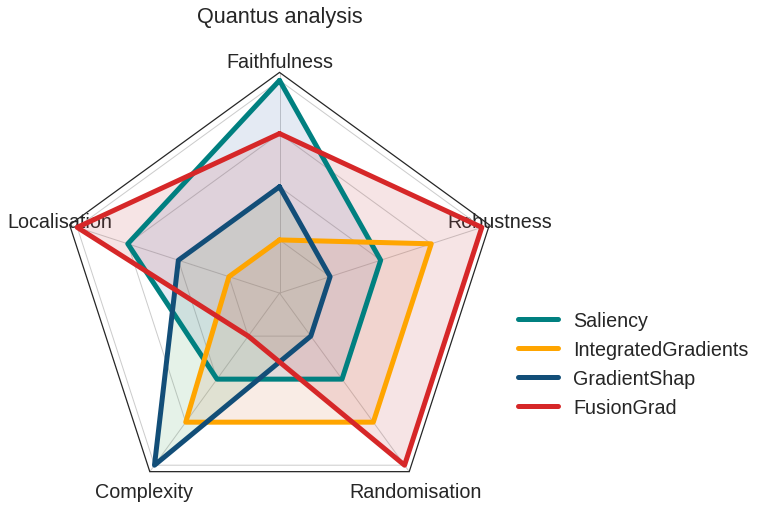

In [ ]:
# Make spyder graph!
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Localisation', '\nComplexity', '\nRandomisation', 'Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
ax.set_title("Quantus analysis",  position=(0.5, 1.1), ha='center')

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_spyder_plot_tutorial.png', dpi=400)
plt.show()

From this graph, we can obtain richer insights into how the different explanation methods are performing: which one is more faithful vs robust vs complex? Does it seem to be a trade-off between the different explanation methods?

Please note that this example is illustrative --- we only used a few input examples for the tutorial to be quick and easy to run.

### 2.3 Sensitivity analysis

Third, in this last exercise we will investigate how much different parameters influence the evaluation outcome i.e., how different explanations methods rank.

We use Faithfulness Correlation by Bhatt et al., 2020 for this example.

In [10]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "random", "uniform", "black", "white"]
subset_sizes = np.array([2, 112, 224, 1792])
iterations = [50, 100]
absolutes = [True, False]
normalisations = [True, False]
similarity_funcs = {"pearson": quantus.correlation_pearson, "spearman": quantus.correlation_spearman}

analysis = {
    "explanation": [],
    "absolute": [],
    "normalisation": [],
    "similarity_func": [],
    "baseline_strategy": [],
    "subset_size": [],
    "iterations": [],
    "faithfulness_score": [],
}

In [100]:
# Loop over the different experimental settings and produce faithfulness scores, depending on the setting and save the results.
if pathlib.Path(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_boxplot_data.csv').is_file():
    df = pd.read_csv(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_boxplot_data.csv')

else:    
    for abs in absolutes:
        for norm in normalisations:
            for baseline in baseline_strategies:
                for subset in subset_sizes:
                    for iter in iterations: 
                        for sim, sim_func in similarity_funcs.items(): 
                            for method, a_batch in explanations.items(): 
                                if method in xai_methods and method == "GradientShap":

                                    scores = np.mean(quantus.FaithfulnessCorrelation(**{"nr_runs": iter,  
                                                                                        "perturb_baseline": baseline,
                                                                                        "perturb_func": quantus.baseline_replacement_by_indices,
                                                                                        "similarity_func": sim_func,  
                                                                                        "subset_size": subset,
                                                                                        "return_aggregate": True,
                                                                                        "abs": abs,  
                                                                                        "normalise": norm,
                                                                                        "normalize_func": quantus.normalise_by_negative,
                                                                                        "disable_warnings": True})(model=model,
                                                                                                                    x_batch=x_batch[sample_indices_viz].reshape(nr_samples_viz, 3, 224, 224).detach().cpu().numpy(),
                                                                                                                    y_batch=y_batch[sample_indices_viz].detach().cpu().numpy(),
                                                                                                                    a_batch=a_batch,
                                                                                                                    s_batch=s_batch[sample_indices_viz].reshape(nr_samples_viz, 1, 224, 224).detach().cpu().numpy(),
                                                                                                                    **{"explain_func": explainer_wrapper,
                                                                                                                    "method": method,
                                                                                                                    "device": device,
                                                                                                                    "img_size": 224,
                                                                                                                    "nr_channels": 3,
                                                                                                                    "posterior_mean": posterior_mean, 
                                                                                                                    "mean": 1.0, 
                                                                                                                    "std": 0.6, 
                                                                                                                    "sg_mean": 0.0, 
                                                                                                                    "sg_std": 0.4,
                                                                                                                    "n": 5,
                                                                                                                    "m": 5,
                                                                                                                    "noise_type": "multiplicative"}))
                                    analysis["explanation"].append(method)
                                    analysis["baseline_strategy"].append(baseline.capitalize())
                                    analysis["normalisation"].append(norm)
                                    analysis["absolute"].append(abs)
                                    analysis["subset_size"].append(subset)
                                    analysis["iterations"].append(iter)
                                    analysis["similarity_func"].append(sim.capitalize())
                                    analysis["faithfulness_score"].append(scores)

        
        df = pd.DataFrame(analysis)
        df.to_csv(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_boxplot_data.csv')

# Post processing!
df = pd.read_csv(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_boxplot_data.csv')

# Calculate rank.
df["faithfulness_score"] = df["faithfulness_score"].abs()
df["rank"] = df.groupby(['baseline_strategy', 'absolute', 'normalisation', 'subset_size', 'iterations', 'similarity_func'])["faithfulness_score"].rank(ascending=False)

# Fix columns.
for col in df.columns:
    df[col].replace('_', ' ', inplace=True)

# Smaller adjustments.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.replace(value="SA", to_replace="Saliency", inplace=True)
df.replace(value="IG", to_replace="IntegratedGradients", inplace=True)
df.replace(value="GS", to_replace="GradientShap", inplace=True)
df.replace(value="FG", to_replace="FusionGrad", inplace=True)
df.columns = map(lambda x: str(x).capitalize(), df.columns)
#df = df.sort_values(by="Faithfulness_score", ascending=False)
df

,Explanation,Absolute,Normalisation,Similarity_func,Baseline_strategy,Subset_size,Iterations,Faithfulness_score,Rank
0,SA,True,True,Pearson,Mean,2,50,0.047743,3.0
1,IG,True,True,Pearson,Mean,2,50,0.102679,1.0
2,FG,True,True,Pearson,Mean,2,50,0.028368,4.0
3,SA,True,True,Spearman,Mean,2,50,0.001502,4.0
4,IG,True,True,Spearman,Mean,2,50,0.053390,2.0
...,...,...,...,...,...,...,...,...,...
1275,GS,False,False,Spearman,White,224,100,0.006191,4.0
1276,GS,False,False,Pearson,White,1792,50,0.061178,2.0
1277,GS,False,False,Spearman,White,1792,50,0.032118,2.0
1278,GS,False,False,Pearson,White,1792,100,0.012363,4.0


In [101]:
# Group by rank.
df_view = df.groupby(["Explanation"])["Rank"].value_counts(normalize=True).mul(100).reset_index(name='Percentage').round(2)
df_view

,Explanation,Rank,Percentage
0,FG,1.0,30.31
1,FG,4.0,25.31
2,FG,2.0,23.44
3,FG,3.0,20.94
4,GS,3.0,28.75
5,GS,1.0,23.75
6,GS,2.0,23.75
7,GS,4.0,23.75
8,IG,2.0,27.19
9,IG,4.0,26.25


In [138]:
# Prepare df for plotting.
df_plot = df.loc[df.Baseline_strategy != "Uniform", :].groupby(["Baseline_strategy", "Explanation"])["Rank"].value_counts(normalize=True).mul(100).reset_index(name='Percentage').round(2)
df_plot["Percentage_by_Baseline"] = df_plot["Percentage"]/4
df_plot["Explanation_by_Rank"] = df_plot["Explanation"].astype(str) + "_" + df_plot["Rank"].astype(str) 
df_plot = df_plot.sort_values(by=["Baseline_strategy", "Explanation", "Rank"], ascending=False)
df_plot.index = np.arange(0, 64)
df_plot.head(10)

,Baseline_strategy,Explanation,Rank,Percentage,Percentage_by_Baseline,Explanation_by_Rank
0,White,SA,4.0,25.00,6.2500,SA_4.0
1,White,SA,3.0,29.69,7.4225,SA_3.0
2,White,SA,2.0,26.56,6.6400,SA_2.0
3,White,SA,1.0,18.75,4.6875,SA_1.0
4,White,IG,4.0,21.88,5.4700,IG_4.0
5,White,IG,3.0,23.44,5.8600,IG_3.0
6,White,IG,2.0,26.56,6.6400,IG_2.0
7,White,IG,1.0,28.12,7.0300,IG_1.0
8,White,GS,4.0,26.56,6.6400,GS_4.0
9,White,GS,3.0,34.38,8.5950,GS_3.0


In [ ]:
# Plotting configs.
sns.set(font_scale=1.8)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_labels = True
include_legend = True
include_labels_and_titles = True

In [143]:
# Make a plot of rank sensitivity: how are the rankings distributed per baseliene strategy and explanation?
fig = px.bar(df_plot, x="Rank", y="Percentage", facet_col="Baseline_strategy", color="Explanation",
            template="simple_white",
             width=900, 
             height=700,
             color_discrete_map={ 
                "SA": "#008080", "IG": "#FFA500", "GS": "#124E78", "FG": "#d62728"
            },)
if include_labels_and_titles:
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
    
else:
    fig.update_layout(showlegend=False)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.for_each_annotation(lambda a: a.update(text=""))

write_image(fig, f'{path}/quantus/tutorials/assets/analysis/analysis_viz_boxplot_plot_tutorial_v1.png', engine="orca")
fig.show()

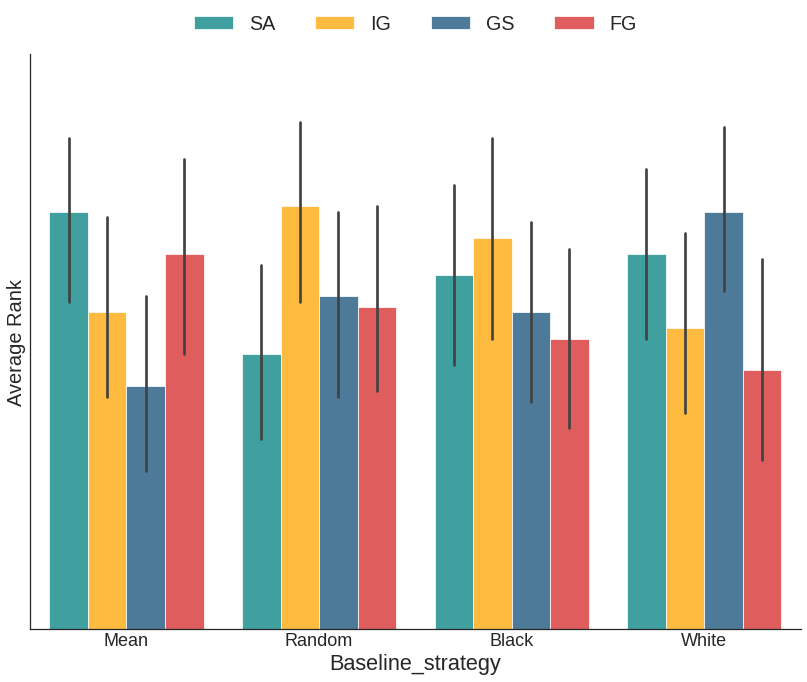

In [139]:
# Make plot of rank sensitivity: how does average rank change over the different parameterisations?
ax = sns.catplot(x="Baseline_strategy", 
                 y="Rank", 
                 hue="Explanation", 
                 kind="bar", 
                 estimator=np.mean, 
                 hue_order=['SA', 'IG', 'GS', "FG"],
                 data=df.loc[df.Baseline_strategy != "Uniform", :], 
                 palette=colours_order, 
                 legend=False, 
                 height=10, 
                 aspect=7/6, 
                 saturation=2, 
                 alpha=0.75)

if include_labels:
    ax.set_ylabels('Average Rank', fontsize=20)
    ax.set_xticklabels(["Mean", "Random", "Black", "White"], fontsize=18)
else:
    plt.xticks([], [])

plt.yticks([], [])
plt.ylim(1.5, 3.2)

if include_legend:
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.savefig(f'{path}/quantus/tutorials/assets/analysis/analysis_viz_boxplot_plot_tutorial_v2.png', dpi=400)

From this example analysis, it becomes clear that distilling any conclusions about what explanation method is the least faithful vs the most faithful --- is difficult --- since the ranking significantly differs in the different baseline strategy settings:

- in 2 out of 4 basline strategy subsets: FG wins
- in 1 out of 4 basline strategy subsets: GS wins
- in 1 out of 4 basline strategy subsets: SA wins

There is not a single method that is consistently ranked the same, the highest or the lowest across the experimental settings, which may imply that there the evaluation is highly sensitive to its paramterisation. 